# Black-Scholes: Monte Carlo pricing

In this notebook, we show how to price European options using Monte Carlo. 

## Geometric Brownian motion: simulation

First, we show how to simulate stock price paths assuming the stock price follows a geometric Brownian motion. The stock price therefore satisfies the stochastic differential equation given by

\begin{equation}
    dS_t = \mu S_t dt + \sigma S_t dW_t
\end{equation}

where $S_t$ is the stock price at time $t$, $\mu$ is the mean return, $\sigma$ is the volatility of returns and $W_t$ is a Wiener process (i.e., Brownian motion) with $W_0 = 0$. The SDE is easily solved using Itô's lemma. Let $Y_t = \log S_t$,

\begin{align}
    dY_t &= \frac{\partial Y_t}{\partial S_t} dS_t + \frac{1}{2} \frac{\partial^2 Y_t}{\partial S_t^2} (dS_t)^2 \notag \\
    &= \frac{1}{S_t} dS_t + \frac{1}{2S_t^2} (dS_t)^2.
\end{align}

We have

\begin{align}
    (dS_t)^2 &= \mu^2 S_t^2 dt^2 + 2\mu \sigma S_t^2 dt \, dW_t + \sigma^2 S_t^2 dW_t^2 \notag \\
    &= \sigma^2 S_t^2 dt.
\end{align}

Note that $\mathcal{O}(dt^2)$ and $\mathcal{O}(dt^{\frac{3}{2}})$ terms go to zero and $(dW_t)^2 = \mathcal{O}(dt)$.

Therefore, we have

\begin{align}
    dY_t &= \frac{1}{S_t} (\mu S_t dt + \sigma S_t dW_t) + \frac{1}{2S_t^2} (\sigma^2 S_t^2 dt) \notag \\
    &= \left(\mu + \frac{1}{2} \sigma^2\right)dt + \sigma dW_t.
\end{align}

Because $dY_t = \log S_t - \log S_0$ and $dW_t = W_t - W_0 = W_t$, we have

\begin{equation}
    S_t = S_0 \exp \left( \left(\mu + \frac{1}{2} \sigma^2\right)t + \sigma W_t \right).
\end{equation}

Because $W_t \sim \phi \sqrt{t}$ with $\phi \sim \mathcal{N}(0, 1)$, we can easily simulate sample paths. Let's define some parameters for a hypothetical stock and generate samples paths. At each time step, we generate the stock price according to

\begin{equation}
    S_{t + dt} = S_t \exp \left( \left(\mu + \frac{1}{2} \sigma^2\right)dt + \sigma \phi \sqrt{dt} \right)
\end{equation}

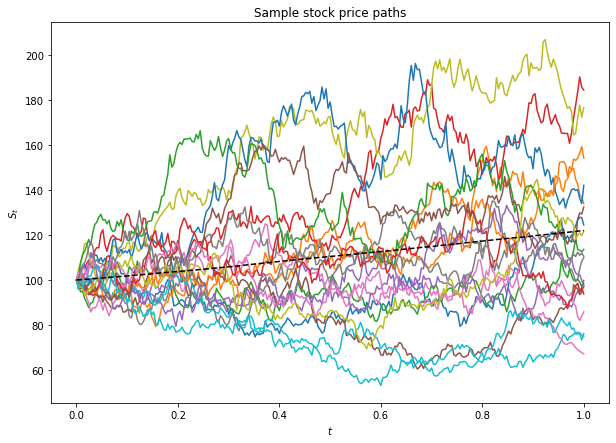

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# # Parameters
mu = 0.2        # mean
sigma = 0.4     # standard deviation
npaths = 20000  # number of paths
nsteps = 250    # number of time steps
npathsplot = 20 # number of paths ploted
T = 1           # time horizon
dt = T/nsteps   # time step
S0 = 100        # Initial stock price

t = np.linspace(0, T, nsteps+1) # time grid

# Compute the increments of the arithmetic brownian motion X = log(S/S0)
dX = (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=(npaths, nsteps))

# Accumulate the increments starting at 0
X = np.concatenate((np.zeros((npaths, 1)), np.cumsum(dX, axis=1)), axis=1)

# Transform to geometric Brownian motion
S = S0*np.exp(X)

# Plot potential stock price paths
fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111)
for i in range(0, npaths, round(npaths/npathsplot)):
    ax.plot(t, S[i,:])
ax.plot(t, np.mean(S, axis=0), 'k--') # mean path
ax.set_title('Sample stock price paths')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S_t$');

Let's plot the distribution of the stock price at maturity and fit a lognormal distribution.

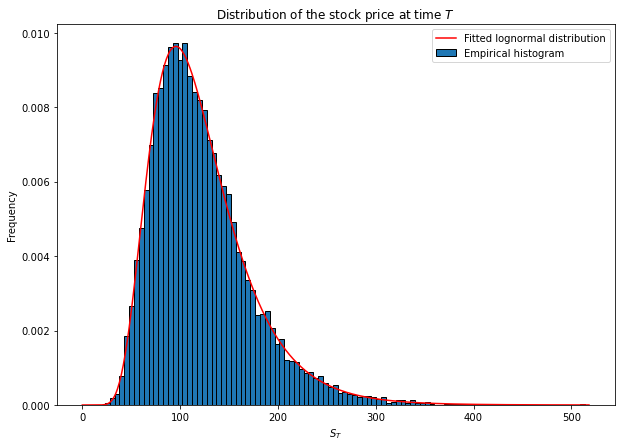

In [9]:
# Plot the distribution of the stock price at maturity
fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111)
ax.hist(S[:,-1], 100, density=True, ec='k', label='Empirical histogram')
ax.set_title(r'Distribution of the stock price at time $T$')
ax.set_xlabel(r'$S_T$')
ax.set_ylabel('Frequency')

# Fit a lognormal distribution
S_grid = range(int(S[:,-1].max())+1)
params = st.lognorm.fit(S[:,-1], scale=100)
pdf = st.lognorm.pdf(S_grid, *params)
ax.plot(S_grid, pdf, 'r', label='Fitted lognormal distribution')
ax.legend();

## Monte Carlo

The value of an option is the discounted value of the expected payoff under a risk-neutral measure. Therefore, we can price the option by simulating many sample price paths, and taking the average of the discounted payoff for each path. Moreover, as the expression is fully deterministic, we do not need to construct the full path (e.g., as for path-dependent options). We only need to simulate the terminal value. The risk-neutral drift is obtained by replacing $\mu$ by $r - q$ ($r$ is the risk-free rate and $q$ is the dividend rate).

Let's define some parameters and price the options. 

In [13]:
# Market parameters
T = 1      # maturity
S0 = 1     # spot price
K = 1.1    # strike price
r = 0.05   # risk-free interest rate
q = 0.02   # dividend rate

# Model parameter
sigma = 0.4 # volatility

# Risk-neutral measure
muRN = r-q-0.5*sigma**2 # drift

# Monte Carlo parameters; npaths = nblocks*nsample
nblocks = 20000 # number of blocks
nsample = 10000 # number of samples per block

# Initialize arrays
Vc_list = np.zeros(nblocks) # call array
Vp_list = np.zeros(nblocks) # put array

# Monte Carlo
for i in range(nblocks):
    X = muRN*T + sigma*np.sqrt(T) * np.random.normal(size=(1, nsample))
    S = S0*np.exp(X)
    Vc_list[i] = np.exp(-r*T)*np.mean(np.maximum(S - K, 0))
    Vp_list[i] = np.exp(-r*T)*np.mean(np.maximum(K - S, 0))

# Final call and put values
Vc = np.mean(Vc_list)
Vp = np.mean(Vp_list)

print('The value of the call is: ' + str(round(Vc, 5)))
print('The value of the put is:  ' + str(round(Vp, 5)))

The value of the call is: 0.12966
The value of the put is:  0.1958


The accuracy of the Monte Carlo simulation can be improved by increasing the number of paths (```nblocks``` $\times$ ```nsample```) or by using variance reduction techniques (e.g., antithetic variates).